In [290]:
# ALLEGHENY DATASET ANALYSIS, GROUP 69

# Introduction and Background:

Preventing and understanding the underlying causes of car accidents continues to be a key public safety issue. Car accidents remain commonplace throughout the United States, retaining its status as a significant cause of death. Thus, it is important that this issue be studied as to further prevent deaths and property damage.
 
Analysts point to a myriad of reasons as to why car accidents occur. According to the Critical Reasons for Crashes Investigated in the National Motor Vehicle Crash Causation Survey (2015), for the 5470 weighted samples, about 50% of the critical reasons for car crashes involve slick roads (loose debris, ice, etc), while fog/rain/snow are involved in around 4% of crashes. Note, however, that these given reasons are not the “primary causes” of the car crashes, just the “immediate reason for the critical pre-crash event and is often the last failure in the causal chain of events leading up to the crash.”
 
In addition, according to the Road Weather Management Program’s “How Do Weather Events Impact Roads?”, precipitation and fog causes a lessens vehicle traction and environmental visibility. The website also states that 22% of crashes from 2005-2014 involve poor weather, including slick road conditions. Wet pavement, rain, and snow/sleet are involved in 73%, 46% and 17%, of weather related crashes, respectively
 
Given this background information, we hoped to find a significant pattern between weather/environmental conditions and poor driving, including injury severity and aggressive driving. By finding this pattern, we hope to provide more insight into car accidents and contribute to preventing more unnecessary destruction.

In [291]:
# General import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import math

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Gmaps API
api = ""
gmaps.configure(api_key=api)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning and Preprocessing

In [292]:
# Load dataframe
df_original = pd.read_csv("reordered2016crashes.csv")

In [293]:
# Create related categories for indexing
category_time = ["CRASH_YEAR", "CRASH_MONTH", "TIME_OF_DAY", "HOUR_OF_DAY"]

category_conditions = ["ILLUMINATION", "WEATHER", "ROAD_CONDITION"]

category_type = ["COLLISION_TYPE", "URBAN_RURAL"]

category_people_count = ["PERSON_COUNT", "VEHICLE_COUNT"] 

category_injury = ["FATAL_COUNT", "INJURY_COUNT", "MAJ_INJ_COUNT", "MOD_INJ_COUNT", "MIN_INJ_COUNT", \
                   "UNK_INJ_DEG_COUNT", "MAX_SEVERITY_LEVEL"]

category_belt = ["UNBELTED", "UNBELTED_OCC_COUNT", "UNB_DEATH_COUNT", "UNB_MAJ_INJ_COUNT", "BELTED_DEATH_COUNT", \
                 "BELTED_MAJ_INJ_COUNT"]

category_age = ["DRIVER_COUNT_16YR", "DRIVER_COUNT_17YR", "DRIVER_COUNT_18YR", "DRIVER_COUNT_19YR", \
                "DRIVER_COUNT_20YR", "DRIVER_COUNT_50_64YR", "DRIVER_COUNT_65_74YR", "DRIVER_COUNT_75PLUS"]

category_location = ["LATITUDE", "LONGITUDE", "DEC_LAT", "DEC_LONG", "STREET_NAME"]

category_alcohol = ["ALCOHOL_RELATED", "DRINKING_DRIVER", "UNDERAGE_DRNK_DRV", "IMPAIRED_DRIVER"]

category_attention = ["CELL_PHONE", "DISTRACTED", "FATIGUE_ASLEEP"]

category_speed = ["LIMIT_65MPH", "SPEEDING", "SPEEDING_RELATED", "AGGRESSIVE_DRIVING"]

# Combine all categories
categories_all = category_time + category_conditions + category_type + category_people_count + \
                category_injury + category_belt + category_age + category_location + \
                category_alcohol + category_attention + category_speed

# Trim original dataframe into relevant data
df_trimmed = df_original[categories_all]

In [294]:
# Drop null values
df_trimmed.dropna()

# Reorder severity levels in ascending order
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(1, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(4, 1)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 4)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(2, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(3, 2)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 3)

In [295]:
# Get latitudes and longitudes of accident locations
df_location = df_trimmed[category_location]
df_location_dec = df_location[['DEC_LAT','DEC_LONG']]
loc_series = df_location_dec.as_matrix(['DEC_LAT','DEC_LONG'])

# Do not plot NaN values on gmaps
loc_list = []
for i in loc_series:
    if( not math.isnan(i[0]) and not math.isnan(i[1])):
        loc_list.append((i[0],i[1]))

# Create gmaps figure and show
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(loc_list)
fig.add_layer(heatmap_layer)
fig

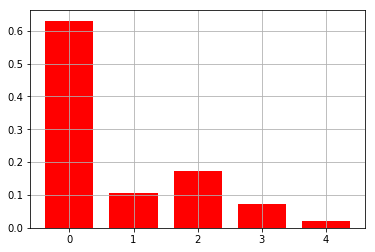

In [296]:
# Get drinking categories
df_isDrunk = df_trimmed[category_alcohol + category_injury]
df_isDrunk = df_isDrunk[["DRINKING_DRIVER","MAX_SEVERITY_LEVEL"]]

# Get if driver was drunk
df_Drunk = df_isDrunk[df_isDrunk['DRINKING_DRIVER'] == 1]
df_Drunk = df_Drunk[df_Drunk['MAX_SEVERITY_LEVEL'] <= 4]

# Plot
graphDrunk = df_Drunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='red', normed=1)
plt.show()

In [297]:
# Clear graphDrunk after use
graphDrunk.clear()

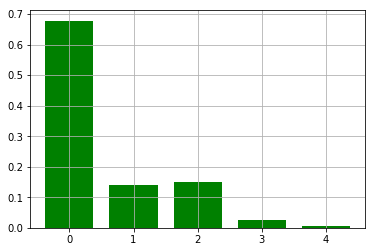

In [298]:
# Plots not drunk histogram
df_NotDrunk = df_isDrunk[df_isDrunk["DRINKING_DRIVER"] == 0]
graphNotDrunk = df_NotDrunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='green', normed=1)
plt.show()

In [299]:
# Clear graphNotDrunk after use
graphNotDrunk.clear()

In [300]:
# Runs linear classifier / t-test on data
outcome, predictors = patsy.dmatrices('MAX_SEVERITY_LEVEL ~ DRINKING_DRIVER', df_isDrunk)

# Use statsmodels to intialize the OLS model
mod = sm.OLS(outcome, predictors)

# Fit the model
res = mod.fit()

# Show results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     MAX_SEVERITY_LEVEL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7288
Date:                Tue, 13 Jun 2017   Prob (F-statistic):              0.393
Time:                        00:02:22   Log-Likelihood:                -33577.
No. Observations:               12900   AIC:                         6.716e+04
Df Residuals:                   12898   BIC:                         6.717e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           2.2196      0.030     

In [301]:
# Create dataframe for weather and injuries
df_weather = df_trimmed[category_conditions + category_injury]

In [302]:
# Injury count with weather
df_weather_inj = df_weather[['WEATHER','INJURY_COUNT']]

# Calculate means for injury count
df_weather_mean_inj = []
df_weather_1_mean_inj =  df_weather[df_weather['WEATHER'] == 1]['INJURY_COUNT'].mean() # Good weather conditions 
df_weather_2_mean_inj =  df_weather[df_weather['WEATHER'] == 2]['INJURY_COUNT'].mean() # Rain
df_weather_3_mean_inj =  df_weather[df_weather['WEATHER'] == 3]['INJURY_COUNT'].mean() # Hail
df_weather_4_mean_inj =  df_weather[df_weather['WEATHER'] == 4]['INJURY_COUNT'].mean() # Snow
df_weather_5_mean_inj =  df_weather[df_weather['WEATHER'] == 5]['INJURY_COUNT'].mean() # Fog
df_weather_6_mean_inj =  df_weather[df_weather['WEATHER'] == 6]['INJURY_COUNT'].mean() # Rain and fog
df_weather_7_mean_inj =  df_weather[df_weather['WEATHER'] == 7]['INJURY_COUNT'].mean() # Hail and fog

# Append to list for injury
df_weather_mean_inj.append(df_weather_1_mean_inj)
df_weather_mean_inj.append(df_weather_2_mean_inj)
df_weather_mean_inj.append(df_weather_3_mean_inj)
df_weather_mean_inj.append(df_weather_4_mean_inj)
df_weather_mean_inj.append(df_weather_5_mean_inj)
df_weather_mean_inj.append(df_weather_6_mean_inj)
df_weather_mean_inj.append(df_weather_7_mean_inj)

# Show mean number of injuries per weather condition
df_weather_mean_inj

[0.592750331251183,
 0.5340909090909091,
 0.39436619718309857,
 0.3852813852813853,
 0.4594594594594595,
 0.3157894736842105,
 0.23076923076923078]

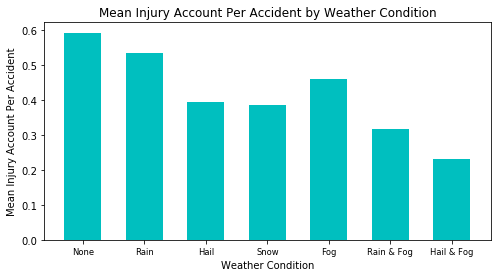

In [365]:
#Bar Graph of ratios of aggressive driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_mean_inj
plt.figure(figsize=(8,4))
weather_mean_inj_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Mean Injury Account Per Accident by Weather Condition")
plt.ylabel('Mean Injury Account Per Accident')
plt.xlabel('Weather Condition')
plt.show()

In [303]:
# Max injury severity level with weather
df_weather_sev = df_weather[['WEATHER', 'MAX_SEVERITY_LEVEL']]
df_weather_sev = df_weather_sev[df_weather_sev['MAX_SEVERITY_LEVEL'] <= 4] # Severity level 8-9 is unknown and redundant

# Calculate means for max severity
df_weather_mean_sev = []
df_weather_1_mean_sev =  df_weather[df_weather['WEATHER'] == 1]['MAX_SEVERITY_LEVEL'].mean() # Good weather conditions 
df_weather_2_mean_sev =  df_weather[df_weather['WEATHER'] == 2]['MAX_SEVERITY_LEVEL'].mean() # Rain
df_weather_3_mean_sev =  df_weather[df_weather['WEATHER'] == 3]['MAX_SEVERITY_LEVEL'].mean() # Hail
df_weather_4_mean_sev =  df_weather[df_weather['WEATHER'] == 4]['MAX_SEVERITY_LEVEL'].mean() # Snow
df_weather_5_mean_sev =  df_weather[df_weather['WEATHER'] == 5]['MAX_SEVERITY_LEVEL'].mean() # Fog
df_weather_6_mean_sev =  df_weather[df_weather['WEATHER'] == 6]['MAX_SEVERITY_LEVEL'].mean() # Rain and fog
df_weather_7_mean_sev =  df_weather[df_weather['WEATHER'] == 7]['MAX_SEVERITY_LEVEL'].mean() # Hail and fog

# Append to list for max severity
df_weather_mean_sev.append(df_weather_1_mean_sev)
df_weather_mean_sev.append(df_weather_2_mean_sev)
df_weather_mean_sev.append(df_weather_3_mean_sev)
df_weather_mean_sev.append(df_weather_4_mean_sev)
df_weather_mean_sev.append(df_weather_5_mean_sev)
df_weather_mean_sev.append(df_weather_6_mean_sev)
df_weather_mean_sev.append(df_weather_7_mean_sev)

# Show mean maximum injury severity level per weather condition
df_weather_mean_sev

[2.287999242854439,
 2.099242424242424,
 1.591549295774648,
 1.8167388167388168,
 1.1891891891891893,
 1.4736842105263157,
 1.8461538461538463]

In [371]:
# Create dataframe for weather with aggressive driving
df_weather_speed = df_trimmed[category_conditions + category_speed]

In [305]:
# Weather with aggressive driving
df_weather_aggressive = df_weather_speed[['WEATHER','AGGRESSIVE_DRIVING']]

# Calculate aggressive ratios
df_weather_agg_ratio = []

# Aggressive driving for good weather conditions
df_weather_1_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 1]['AGGRESSIVE_DRIVING'] 
df_weather_1_agg_ratio = df_weather_1_agg.value_counts()[1] / (df_weather_1_agg.value_counts()[0] + df_weather_1_agg.value_counts()[1])

# Aggressive driving for rainy weather conditions
df_weather_2_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 2]['AGGRESSIVE_DRIVING'] 
df_weather_2_agg_ratio = df_weather_2_agg.value_counts()[1] / (df_weather_2_agg.value_counts()[0] + df_weather_2_agg.value_counts()[1])

# Aggressive driving for hailing weather conditions
df_weather_3_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 3]['AGGRESSIVE_DRIVING'] 
df_weather_3_agg_ratio = df_weather_3_agg.value_counts()[1] / (df_weather_3_agg.value_counts()[0] + df_weather_3_agg.value_counts()[1])

# Aggressive driving for snowy weather conditions
df_weather_4_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 4]['AGGRESSIVE_DRIVING'] 
df_weather_4_agg_ratio = df_weather_4_agg.value_counts()[1] / (df_weather_4_agg.value_counts()[0] + df_weather_4_agg.value_counts()[1])

# Aggressive driving for foggy weather conditions
df_weather_5_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 5]['AGGRESSIVE_DRIVING'] 
df_weather_5_agg_ratio = df_weather_5_agg.value_counts()[1] / (df_weather_5_agg.value_counts()[0] + df_weather_5_agg.value_counts()[1])

# Aggressive driving for rainy and foggy weather conditions
df_weather_6_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 6]['AGGRESSIVE_DRIVING'] 
df_weather_6_agg_ratio = df_weather_6_agg.value_counts()[1] / (df_weather_6_agg.value_counts()[0] + df_weather_6_agg.value_counts()[1])

# Aggressive driving for hailing and foggy weather conditions
df_weather_7_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 7]['AGGRESSIVE_DRIVING'] 
df_weather_7_agg_ratio = df_weather_7_agg.value_counts()[1] / (df_weather_7_agg.value_counts()[0] + df_weather_7_agg.value_counts()[1])

# Append to list
df_weather_agg_ratio.append(df_weather_1_agg_ratio)
df_weather_agg_ratio.append(df_weather_2_agg_ratio)
df_weather_agg_ratio.append(df_weather_3_agg_ratio)
df_weather_agg_ratio.append(df_weather_4_agg_ratio)
df_weather_agg_ratio.append(df_weather_5_agg_ratio)
df_weather_agg_ratio.append(df_weather_6_agg_ratio)
df_weather_agg_ratio.append(df_weather_7_agg_ratio)

# Print out ratios per weather condition
df_weather_agg_ratio

[0.48485708877531708,
 0.55227272727272725,
 0.46478873239436619,
 0.46897546897546899,
 0.48648648648648651,
 0.42105263157894735,
 0.38461538461538464]

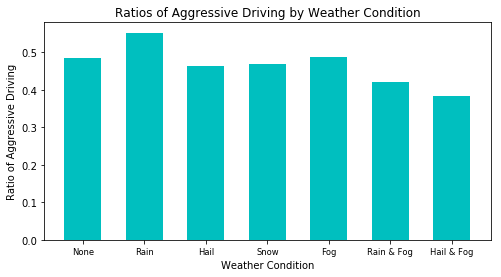

In [367]:
#Bar Graph of ratios of aggressive driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_agg_ratio
plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratios of Aggressive Driving by Weather Condition")
plt.ylabel('Ratio of Aggressive Driving')
plt.xlabel('Weather Condition')
plt.show()

In [388]:
# Weather with speeding
df_weather_speeding = df_weather_speed[['WEATHER','SPEEDING']]
NUM_WEATHER_COND = 7;

# Calculate speeding ratios (speeding vs total)
weather_spd_ratios = [0 for i in range(NUM_WEATHER_COND)]

for i in range(1,NUM_WEATHER_COND + 1):
    weather_spd = df_weather_speeding[df_weather_speeding['WEATHER'] == i]['SPEEDING']
    df_vc = weather_spd.value_counts() #counts the number of 0s for no speeding, 1s for speeding
    df_vc_idx = df_vc.index.tolist() #gets the values: [0, 1] in this case
    if len(df_vc) > 1:
        ratio = df_vc[1]/(df_vc[0] + df_vc[1]) #ratio of speeding vs total
    else:
        if df_vc_idx[0] == 0: #all accidents non speeding
            ratio = 0;
        else:
            ratio = 1; #all accidents speeding
    print(df_vc) #print the value counts
    weather_spd_ratios[i-1] = ratio

# Print out ratios per weather condition
weather_spd_ratios

0    10151
1      415
Name: SPEEDING, dtype: int64
0    1283
1      37
Name: SPEEDING, dtype: int64
0    69
1     2
Name: SPEEDING, dtype: int64
0    685
1      8
Name: SPEEDING, dtype: int64
0    37
Name: SPEEDING, dtype: int64
0    19
Name: SPEEDING, dtype: int64
0    13
Name: SPEEDING, dtype: int64


[0.03927692598902139,
 0.02803030303030303,
 0.028169014084507043,
 0.011544011544011544,
 0,
 0,
 0]

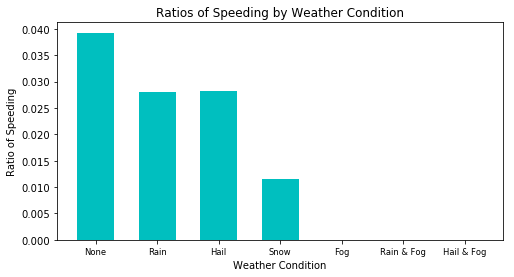

In [389]:
#Bar Graph of ratios of speeding per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = weather_spd_ratios
plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratios of Speeding by Weather Condition")
plt.ylabel('Ratio of Speeding')
plt.xlabel('Weather Condition')
plt.show()

When determining the ratios above, we found that they were 0 in some cases. Taking a look at the value counts, we discovered that for certain weather conditions such as 5, 6, 7 (Fog, Rain & Fog, Hail & Fog respectively) had a very small number of accidents. Even under 30 accidents in two cases. So their ratios being 0 may not be entirely accurate. Even hail had a relatively small number of 69 with respect to the general range of the ratios (all being under 4%). Nonetheless, there does seem to be a trend of a lower tendency for speeding-related accidents.

In [390]:
# Create dataframe for illumination conditions with injury counts
df_light = df_trimmed[category_conditions + category_injury]
df_light = df_weather[['ILLUMINATION','INJURY_COUNT']]

# Calculate mean injury counts per lighting condition
df_light_mean = []
df_light_1_mean =  df_light[df_light['ILLUMINATION']==1]['INJURY_COUNT'].mean() # Daylight
df_light_2_mean =  df_light[df_light['ILLUMINATION']==2]['INJURY_COUNT'].mean() # Dark - no street light
df_light_3_mean =  df_light[df_light['ILLUMINATION']==3]['INJURY_COUNT'].mean() # Dark - street light
df_light_4_mean =  df_light[df_light['ILLUMINATION']==4]['INJURY_COUNT'].mean() # Dusk
df_light_5_mean =  df_light[df_light['ILLUMINATION']==5]['INJURY_COUNT'].mean() # Dawn
df_light_6_mean =  df_light[df_light['ILLUMINATION']==6]['INJURY_COUNT'].mean() # Dark - unknown roadway lighting

# Append means to list
df_light_mean.append(df_light_1_mean)
df_light_mean.append(df_light_2_mean)
df_light_mean.append(df_light_3_mean)
df_light_mean.append(df_light_4_mean)
df_light_mean.append(df_light_5_mean)
df_light_mean.append(df_light_6_mean)

# Print means per lighting condition
df_light_mean

[0.6070865186263803,
 0.4595744680851064,
 0.517541316323572,
 0.5799086757990868,
 0.48258706467661694,
 0.5555555555555556]

In [234]:
# Aggressive driving with illumination
df_ill_aggressive = df_weather_speed[['ILLUMINATION','AGGRESSIVE_DRIVING']]

# Calculate aggression with illumination
df_ill_agg_ratio = []

# Aggressive driving for daytime conditions
df_ill_1_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 1]['AGGRESSIVE_DRIVING'] 
df_ill_1_agg_ratio = df_ill_1_agg.value_counts()[1] / (df_ill_1_agg.value_counts()[0] + df_ill_1_agg.value_counts()[1])

# Aggressive driving for dark, no street light conditions
df_ill_2_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 2]['AGGRESSIVE_DRIVING'] 
df_ill_2_agg_ratio = df_ill_2_agg.value_counts()[1] / (df_ill_2_agg.value_counts()[0] + df_ill_2_agg.value_counts()[1])

# Aggressive driving for dark, with street light conditions
df_ill_3_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 3]['AGGRESSIVE_DRIVING'] 
df_ill_3_agg_ratio = df_ill_3_agg.value_counts()[1] / (df_ill_3_agg.value_counts()[0] + df_ill_3_agg.value_counts()[1])

# Aggressive driving for dusk conditions
df_ill_4_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 4]['AGGRESSIVE_DRIVING'] 
df_ill_4_agg_ratio = df_ill_4_agg.value_counts()[1] / (df_ill_4_agg.value_counts()[0] + df_ill_4_agg.value_counts()[1])

# Aggressive driving for dawn conditions
df_ill_5_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 5]['AGGRESSIVE_DRIVING'] 
df_ill_5_agg_ratio = df_ill_5_agg.value_counts()[1] / (df_ill_5_agg.value_counts()[0] + df_ill_5_agg.value_counts()[1])

# Aggressive driving for dark, unknown conditions
df_ill_6_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 6]['AGGRESSIVE_DRIVING'] 
df_ill_6_agg_ratio = df_ill_6_agg.value_counts()[1] / (df_ill_6_agg.value_counts()[0] + df_ill_6_agg.value_counts()[1])

# Append to list
df_ill_agg_ratio.append(df_ill_1_agg_ratio)
df_ill_agg_ratio.append(df_ill_2_agg_ratio)
df_ill_agg_ratio.append(df_ill_3_agg_ratio)
df_ill_agg_ratio.append(df_ill_4_agg_ratio)
df_ill_agg_ratio.append(df_ill_5_agg_ratio)
df_ill_agg_ratio.append(df_ill_6_agg_ratio)

# Print out ratios per illumination condition
df_ill_agg_ratio

[0.52323747118068198,
 0.39432624113475179,
 0.42853000869817337,
 0.53881278538812782,
 0.40298507462686567,
 0.37037037037037035]

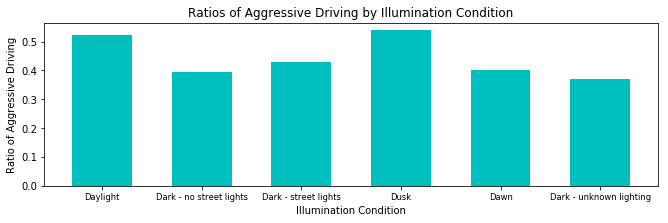

In [383]:
#Bar Graph of ratios of aggressive driving per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = df_ill_agg_ratio
plt.figure(figsize=(11,3))
ill_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Ratios of Aggressive Driving by Illumination Condition')
plt.ylabel('Ratio of Aggressive Driving')
plt.xlabel('Illumination Condition')
plt.show()

In [385]:
# Create dataframe for weather with month
df_weather_time = df_trimmed[category_conditions + category_time]

In [393]:
df_month = df_weather_time[['CRASH_MONTH']]
NUM_MONTH = 12;

# Calculate speeding ratios (speeding vs total)
month_counts = df_month['CRASH_MONTH'].value_counts().sort_index()

# Print out ratios per weather condition
month_counts

1     1305
2     1006
3      904
4     1035
5     1038
6     1044
7      973
8     1091
9     1017
10    1149
11    1072
12    1266
Name: CRASH_MONTH, dtype: int64

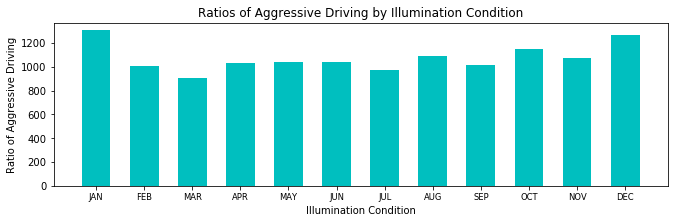

In [394]:
x_lbls = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
y = month_counts
plt.figure(figsize=(11,3))
month_count_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Number of Accidents by Month')
plt.ylabel('Number of Accidents')
plt.xlabel('Month')
plt.show()

# Data Analysis and Results:

# Conclusion/Discussion: